In [9]:
import pandas as pd
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self,path,target_column,drop_cols,future_steps, p_lag=0, test=False):
        self.df = pd.read_csv(path)
        self.df = self.df.drop(drop_cols, axis=1)
        if test: 
            self.df = self.df.iloc[round(len(self.df)*0.8):len(self.df),:]
        else: 
            self.df = self.df.iloc[0:round(len(self.df)*0.8),:]
        self.p_lag = p_lag
        self.len_df_minus_lag = len(self.df) - p_lag - future_steps
        self.target_column = target_column
        self.future_steps = future_steps
        
    def __len__(self):
        return self.len_df_minus_lag

    def __getitem__(self, idx):
        input_p_lag = torch.tensor(self.df.iloc[(idx):(idx + self.p_lag),:].astype(float).to_numpy().transpose().reshape(1,-1), requires_grad=True)
        #input = input_p_lag.reshape(-1)
        target = torch.tensor(self.df[self.target_column].iloc[(idx + self.p_lag): (idx + self.p_lag + self.future_steps),:].astype(float).to_numpy()).reshape(1,-1)
        return input_p_lag, target

In [12]:
from torch.utils.data import DataLoader
train_data = DataLoader(TimeSeriesDataset(path='ETTm2.csv',target_column = ['OT'],drop_cols='date',p_lag=7,test=False, future_steps=7))
c = 0
for i,t in train_data: 
    print(i)
    print(t)
    c += 1
    if c == 2: 
        break

tensor([[[41.1300, 39.6220, 38.8680, 35.5180, 37.5280, 37.6120, 36.2720,
          12.4810, 11.3090, 10.5550,  9.2140, 10.1360, 10.3030,  9.4660,
          36.5360, 35.5440, 34.3650, 32.5690, 33.9360, 33.2120, 32.9170,
           9.3550,  8.5510,  7.5860,  8.7120,  7.5320,  7.5320,  7.2110,
           4.4240,  3.2090,  4.4350,  4.4350,  4.4350,  3.9130,  3.9130,
           1.3110,  1.2580,  1.2580,  1.2150,  1.2150,  1.3010,  0.0000,
          38.6620, 38.2230, 37.3440, 37.1240, 37.1240, 36.9040, 36.9040]]],
       dtype=torch.float64, grad_fn=<StackBackward0>)
tensor([[[36.4650, 36.4650, 36.4650, 35.8060, 34.9270, 33.6085, 32.9490]]],
       dtype=torch.float64)
tensor([[[39.6220, 38.8680, 35.5180, 37.5280, 37.6120, 36.2720, 32.7530,
          11.3090, 10.5550,  9.2140, 10.1360, 10.3030,  9.4660,  7.8740,
          35.5440, 34.3650, 32.5690, 33.9360, 33.2120, 32.9170, 30.7190,
           8.5510,  7.5860,  8.7120,  7.5320,  7.5320,  7.2110,  6.2730,
           3.2090,  4.4350,  4.4350,

In [16]:
import math
import torch.nn as nn
from torch.nn.functional import normalize

import torch
from torch import nn

class DecompositionLayer(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0) 

    def forward(self, x):
        num_of_pads = (self.kernel_size - 1) // 2
        front = x[:, 0:1, :].repeat(1, num_of_pads, 1)
        end = x[:, -1:, :].repeat(1, num_of_pads, 1)
        x_padded = torch.cat([front, x, end], dim=1)

        x_trend = self.avg(x_padded.permute(0, 2, 1)).permute(0, 2, 1)
        x_seasonal = x - x_trend
        return x_seasonal, x_trend

class ARNet(nn.Module):
    def __init__(self, p_lag, n_features, future_steps, decomp_kernel_size = 7):
        super(ARNet, self).__init__()
        self.input_trend_layer = nn.Linear(p_lag * n_features, math.ceil(p_lag * n_features/2))
        self.output_trend_layer = nn.Linear(math.ceil(p_lag * n_features/2), future_steps)

        self.input_seasonal_layer = nn.Linear(p_lag * n_features, math.ceil(p_lag * n_features/2))
        self.output_seasonal_layer = nn.Linear(math.ceil(p_lag * n_features/2), future_steps)

        self.decomp_layer = DecompositionLayer(decomp_kernel_size)

        self.criterion = nn.MSELoss()

    def forward(self, input):
        input = input.float()

        input_season, input_trend = self.decomp_layer(input)

        x_season = self.input_seasonal_layer(input_season)
        y_hat_season = self.output_seasonal_layer(x_season)

        x_trend = self.input_trend_layer(input_trend)
        y_hat_trend = self.output_trend_layer(x_trend)
        
        return y_hat_season + y_hat_trend

In [25]:
from torch.utils.data import DataLoader

p_lag = 30

net = ARNet(p_lag=p_lag, n_features=7, future_steps=7, decomp_kernel_size=7)

train_data = DataLoader(TimeSeriesDataset(path='ETTm2.csv', future_steps= 7, target_column = ['OT'],drop_cols='date',p_lag=p_lag,test=False))
train_loss_list = []
test_data = DataLoader(TimeSeriesDataset(path='ETTm2.csv',future_steps= 7, target_column = ['OT'],drop_cols='date',p_lag=p_lag,test=True))
test_loss_list = []

torch.set_grad_enabled(True)
optimizer = torch.optim.Adam(net.parameters(), lr=1.e-5)
running_train_loss = 0.
running_test_loss = 0.
train_counter = 1
test_counter = 1
for epoch in range(1): 
    print("---------------------------")
    for i, data in enumerate(train_data):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = net.criterion(outputs.squeeze(0), labels.squeeze(0))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
        optimizer.step()
        running_train_loss += loss.item()
        train_counter += 1
        if train_counter % 10000 == 0: 
            print(f"Current (running) training loss at iteration {train_counter} : {running_train_loss/train_counter}")

    train_loss_list.append(running_train_loss/train_counter)
        
    for i, data in enumerate(test_data):
        inputs, test_labels = data
        output = net(inputs)
        test_loss = net.criterion(output.squeeze(0), test_labels.squeeze(0))
        running_test_loss += test_loss.item()
        test_counter += 1
    test_loss_list.append(running_test_loss/test_counter)

    if epoch % 1 == 0: 
        print(f"Epoch {epoch}: ")
        print(f"Running (training) loss is {running_train_loss/train_counter}.")
        print(f"Test loss is {running_test_loss/test_counter}.")
        print("---------------------------")

#for i, data in enumerate(test_data):
#    inputs, labels = data
#    output = net(inputs)
#    print(f"predicted output is {output.item()} and true value is {labels.item()}")


---------------------------
torch.Size([1, 7])
torch.Size([1, 7])
tensor(1006.4735, grad_fn=<MseLossBackward0>)


KeyboardInterrupt: 

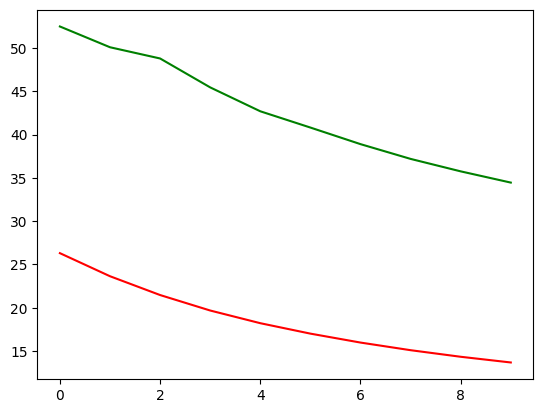

In [6]:
import matplotlib.pyplot as plt
plt.plot(test_loss_list, 'g', train_loss_list, 'r')
plt.show()